In [3]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from statsmodels.gam.api import GLMGam, BSplines

import seaborn as sns
from IPython.display import Image

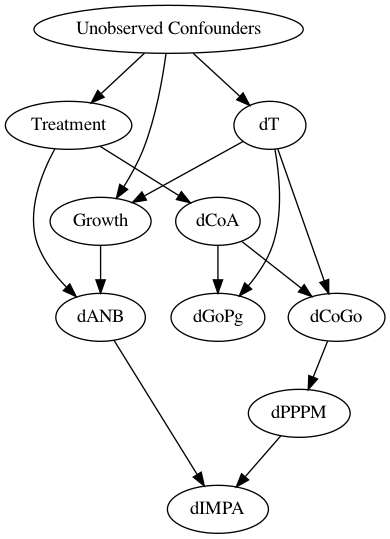

In [9]:
Image('task_image.png')

In [4]:
df = pd.read_csv('malocclusion.csv')
df

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0
...,...,...,...,...,...,...,...,...,...
138,0.8,-2.1,-2.0,2.7,2.0,3.3,5,1,1
139,2.1,0.7,1.4,8.2,12.8,9.1,10,1,1
140,-0.2,-3.3,-2.7,6.8,3.4,10.9,4,1,1
141,1.5,-3.5,1.8,4.6,6.5,6.2,5,1,1


In [11]:
df.describe()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,-0.227273,-1.374825,-0.785315,5.987413,7.730769,6.732867,4.706294,0.405594,0.461538
std,1.826225,2.715046,5.080894,4.469692,5.532417,4.595141,2.550427,0.492733,0.500271
min,-5.100000,-9.300000,-19.000000,-0.900000,-1.400000,-2.600000,1.000000,0.000000,0.000000
25%,-1.350000,-2.750000,-3.450000,1.800000,3.200000,3.050000,3.000000,0.000000,0.000000
50%,-0.300000,-1.400000,-0.400000,5.500000,6.200000,6.300000,4.000000,0.000000,0.000000
75%,0.950000,0.050000,2.100000,9.750000,12.750000,10.350000,6.000000,1.000000,1.000000
max,4.900000,6.500000,12.000000,20.000000,23.300000,17.500000,12.000000,1.000000,1.000000


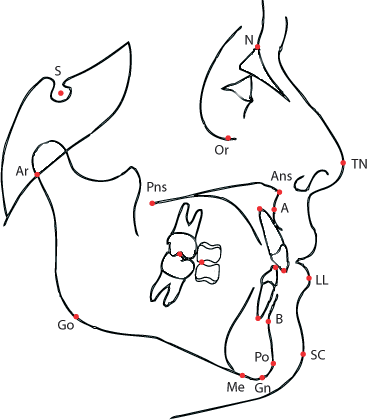

In [29]:
Image('face.png')

- Treatment: untreated (0) or treated (1).
- Growth: a binary variable with values Good or Bad, determined on the basis of CoGn-CoA.
- ANB: angle between Down's points A and B (degrees).
- IMPA: incisor-mandibular plane angle (degrees).
- PPPM: palatal plane - mandibular plane angle (degrees).
- CoA: total maxillary length from condilion to Down's point A (mm).
- GoPg: length of mandibular body from gonion to pogonion (mm).
- CoGo: length of mandibular ramus from condilion to pogonion (mm).
 
In fact, that ANB is caused by either Treatment or Growth

Naive estimator of ATE:

In [36]:
df.dANB[df.Treatment == 1].mean() - df.dANB[df.Treatment == 0].mean()

2.0287878787878784

In [55]:
df.Growth[df.Treatment == 1].mean() - df.Growth[df.Treatment == 0].mean()

0.1471861471861472

## Treatment -> Growth

### On the Causal Graph there is no edge between Treatment and Growth and the fact that dIMPA is decsendand and colider it can be conditioned from Growth


Let us perform the linear regression with all possible regressors

In [35]:
m = smf.ols('dIMPA ~ dANB + dCoA + dGoPg + dCoGo + dPPPM + Treatment + Growth', data=df)
fitted = m.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  dIMPA   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     3.739
Date:                Fri, 29 Apr 2022   Prob (F-statistic):           0.000985
Time:                        06:27:42   Log-Likelihood:                -422.18
No. Observations:                 143   AIC:                             860.4
Df Residuals:                     135   BIC:                             884.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7467      0.989     -0.755      0.4

The interpratation of the result obtained:

    1) ANB -> IMPA: Assume, that the angle between A and B increased.
    For example, this is possible when:
    - The lower jaw leaned forward
    - The lower jaw has grown
    The consequence of increasing ANB will be the return of the incisors to their normal position, which in turn will cause an increase in IMPA.

    2) PPPM -> IMPA: If the incisors return to their normal position, AND increases, which in turn reduces PPPM

    3) Treatment -> IMPA: During the intervention (Treatment), the lower jaw gradually takes the correct (normal) position -> the incisors return to the correct position -> ANB increases -> IMPA increases -> the Malocclusion returns to normal

    4) Growth -> IMPA: Possitive effect

According to the analysis above we can take as main features: dPPPM and dANB

### Propensity score weighting

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# classifier to estimate the propensity score
cls = LogisticRegression()

# calibration of the classifier
cls = CalibratedClassifierCV(cls)

X = df[['dPPPM', 'dANB']]
y = df['Treatment']
cls.fit(X, y)
df['TrProba'] = cls.predict_proba(X)[:,1].tolist()
df.head()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment,TrProba,weight,DR0,DR1
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0,0.077492,1.084002,-4.399354,-6.213511
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0,0.340456,1.516198,5.838612,-3.836136
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0,0.274933,1.379182,-8.037106,-2.748223
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0,0.318792,1.467981,-17.590672,-3.038643
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0,0.240435,1.316543,-8.657750,-4.813399


In [68]:
df['weight'] = df['Treatment'] / df['TrProba'] + (1 - df['Treatment']) / (1 - df['TrProba'])
df

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment,TrProba,weight,DR0,DR1
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0,0.077492,1.084002,-4.399354,-6.213511
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0,0.340456,1.516198,5.838612,-3.836136
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0,0.274933,1.379182,-8.037106,-2.748223
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0,0.318792,1.467981,-17.590672,-3.038643
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0,0.240435,1.316543,-8.657750,-4.813399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.8,-2.1,-2.0,2.7,2.0,3.3,5,1,1,0.678516,1.473804,0.889422,-2.506602
139,2.1,0.7,1.4,8.2,12.8,9.1,10,1,1,0.771622,1.295972,1.552123,2.363357
140,-0.2,-3.3,-2.7,6.8,3.4,10.9,4,1,1,0.547990,1.824851,0.312480,-4.080772
141,1.5,-3.5,1.8,4.6,6.5,6.2,5,1,1,0.817591,1.223105,1.451025,1.972019


In [69]:
m = smf.wls('dIMPA ~ dPPPM + Treatment + dANB', data=df, weights=df['weight'])
fitted = m.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                  dIMPA   R-squared:                       0.159
Model:                            WLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     8.750
Date:                Fri, 29 Apr 2022   Prob (F-statistic):           2.35e-05
Time:                        07:20:21   Log-Likelihood:                -430.90
No. Observations:                 143   AIC:                             869.8
Df Residuals:                     139   BIC:                             881.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9561      0.553     -1.730      0.0

The ATE is -2.0583

### Doubly robust estimator

In [70]:
from sklearn.linear_model import LinearRegression

y0 = LinearRegression().fit(df[df.Treatment == 0][['dPPPM', 'dANB']], df[df.Treatment == 0]['dIMPA']).predict(df[['dPPPM', 'dANB']])
y1 = LinearRegression().fit(df[df.Treatment == 1][['dPPPM', 'dANB']], df[df.Treatment == 1]['dIMPA']).predict(df[['dPPPM', 'dANB']])

df['DR0'] = (1-df['Treatment'])*(df['dIMPA'] - y0) / (1-df['TrProba']) + y0
df['DR1'] =  df['Treatment']*(df['dIMPA'] - y1) / df['TrProba']  + y1

df['DR1'].mean() - df['DR0'].mean()

-2.035143733011298

The ATE is -2.0351

## Treatment -> ANB

### Since we have the relation between dANB and Treatment on the Graph we can omit all colliders and perform the regression and use backdoor adjustment


### Propensity score weighting

In [73]:
X = df[['dPPPM', 'dCoA', 'dCoGo']]
y = df['Treatment']
cls.fit(X, y)
df['TrProba'] = cls.predict_proba(X)[:,1].tolist()
df.head()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment,TrProba,weight,DR0,DR1
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0,0.145955,1.084002,-4.399354,-6.213511
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0,0.277747,1.516198,5.838612,-3.836136
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0,0.301812,1.379182,-8.037106,-2.748223
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0,0.860820,1.467981,-17.590672,-3.038643
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0,0.521193,1.316543,-8.657750,-4.813399


In [74]:
df['weight'] = df['Treatment'] / df['TrProba'] + (1 - df['Treatment']) / (1 - df['TrProba'])
df

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment,TrProba,weight,DR0,DR1
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0,0.145955,1.170899,-4.399354,-6.213511
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0,0.277747,1.384556,5.838612,-3.836136
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0,0.301812,1.432280,-8.037106,-2.748223
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0,0.860820,7.184921,-17.590672,-3.038643
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0,0.521193,2.088526,-8.657750,-4.813399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.8,-2.1,-2.0,2.7,2.0,3.3,5,1,1,0.250977,3.984421,0.889422,-2.506602
139,2.1,0.7,1.4,8.2,12.8,9.1,10,1,1,0.607272,1.646707,1.552123,2.363357
140,-0.2,-3.3,-2.7,6.8,3.4,10.9,4,1,1,0.439229,2.276717,0.312480,-4.080772
141,1.5,-3.5,1.8,4.6,6.5,6.2,5,1,1,0.343942,2.907470,1.451025,1.972019


In [75]:
m = smf.wls('dANB ~ dPPPM + Treatment + dCoA + dCoGo', data=df, weights=df['weight'])
fitted = m.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.396
Model:                            WLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     22.59
Date:                Fri, 29 Apr 2022   Prob (F-statistic):           2.28e-14
Time:                        07:31:22   Log-Likelihood:                -257.68
No. Observations:                 143   AIC:                             525.4
Df Residuals:                     138   BIC:                             540.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9321      0.239     -3.904      0.0

ATE is 1.5010

### Propensity score matching

In [80]:
causal = CausalModel(
    Y=df['dANB'].values, # outcome
    D=df['Treatment'].values, # treatment
    X=df['TrProba'].values
)
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.509      0.681      2.216      0.027      0.175      2.843
           ATC      1.171      1.049      1.116      0.264     -0.885      3.227
           ATT      1.903      0.592      3.215      0.001      0.743      3.063

